<img src='https://seeklogo.com/images/S/sharif-university-of-technology-logo-4647B7749E-seeklogo.com.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    ML for Bioinformatics <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
<font color=3C99D size=5>
    Project: Single-Cell RNA Sequencing Analysis <br>

>

    Arian Amani (arianamaani@gmail.com)
    Amir Mohammad Isazadeh (amirmohammadisazadeh@gmail.com)
    Alireza Gargoori Motlagh (alireza.agm@gmail.com)

    

Please take note of the important deadlines. The deadline for submitting your proposed title for the project is set for **10 Mordad**. Make sure to have your title ready and submitted by this date for consideration. As for the completion of the entire project, including both phases, the final deadline is scheduled for **22 Mordad**. This gives you ample time to work through each phase thoroughly and deliver a comprehensive and well-executed project. Please adhere to these deadlines diligently to ensure a successful and timely completion of the project.

The first and second phases of the project will each be graded on a total of 2 points, along with an additional bonus point that can be earned based on the quality and effectiveness of your results and answers. This means that in addition to the regular evaluation, you have the opportunity to gain extra credit for exceptional work and insightful responses.

Best of luck, and we look forward to your excellent work!

# Single-Cell RNA Sequencing

Single-cell RNA sequencing (scRNA-seq) is a powerful technique used in molecular biology to study gene expression at the single-cell level. It allows researchers to profile the transcriptome of individual cells, providing insights into cellular heterogeneity and identifying distinct cell types within a tissue or sample.

By analyzing gene expression at the single-cell level, scRNA-seq enables researchers to gain insights into the diversity of cell types, identify rare cell populations, characterize cell states, and study cellular dynamics in various biological processes, such as development, disease progression, or response to treatments.

It's important to note that scRNA-seq is a rapidly evolving field, and new methods and technologies are continuously being developed to improve sensitivity, throughput, and the ability to capture additional molecular features beyond gene expression, such as chromatin accessibility or protein levels.

In this project, first you are going to get familiar with the general steps of analyzing scRNA-seq data, through different steps of preprocessing and clustering. After that, you should propose a topic to work on individually as the main part of your project. Some options are provided and discussed in the end of this notebook.

To get yourself introduced with scRNA-seq data analysis, we highly recommend you to read the following paper:

***Current best practices in single-cell RNA-seq analysis: a tutorial
(Malte D Luecken & Fabian J Theis, 2019)***

# Short Questions

Answer the following questions:

---


*   Compare the typical bulk RNA-seq vs scRNA-seq and state what advantages scRNA-seq data could provide to analyse.

    <code> Your Answer </code>

---
*   What are the key steps involved in performing a scRNA-seq experiment?

    <code> Your Answer </code>

---
*   Explain the difficulties with scRNA-seq data acquisition. Specifically, explain what are doublets and dropouts.

    <code> Your Answer </code>

---
*   Can scRNA-seq capture other molecular features beyond gene expression, such as chromatin accessibility or protein levels?

  <code> Your Answer </code>

In [ ]:
!pip install scanpy

In [ ]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
import gc

In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3

# Pre-processing

Preprocessing plays a crucial role in single-cell RNA sequencing (scRNA-seq) data analysis. It involves a series of computational steps aimed at transforming raw sequencing data into a format suitable for downstream analysis. Preprocessing tasks include quality control, filtering, normalization, gene expression estimation, and handling technical artifacts. Proper preprocessing is vital because scRNA-seq data often suffer from technical noise, dropout events, and batch effects, which can obscure the true biological signal. By carefully preprocessing the data, researchers can improve the accuracy, reliability, and interpretability of scRNA-seq results, enabling the identification of meaningful biological patterns, cell types, and regulatory networks.

The general pipeline for scRNA-seq data analysis could be summarized in the following figure:

![](https://drive.google.com/uc?id=1qfTOH9ORfFX09kxSs3MqybMOdYxRVQbP)

For this section you can use the [scanpy](https://scanpy.readthedocs.io/en/stable/) package. Scanpy is a scalable toolkit for analyzing single-cell gene expression data. It includes preprocessing, visualization, clustering, trajectory inference and differential expression testing. The Python-based implementation efficiently deals with datasets of more than one million cells. The algorithms are implemented for the analysis via scanpy as described in [Wolf18].

Here, we will use 2 different datasets for different parts. One for Quality Control and Normalization, and another one for Batch Correction. (The second dataset is already normalized)

`Scanpy` works with data types called [`AnnData`](https://anndata.readthedocs.io/en/stable/generated/anndata.AnnData.html#anndata.AnnData).

So we are going to load our datasets into `AnnData` objects. [`anndata`](https://anndata.readthedocs.io/) is a Python package for handling annotated data matrices in memory and on disk, positioned between pandas and xarray. anndata offers a broad range of computationally efficient features including, among others, sparse data support, lazy operations, and a PyTorch interface.

The gene expression is saved under `adata.X` as a matrix `(n_cells, n_genes)`.

`adata.var` holds information about each of the genes `(n_genes, m)` and `adata.obs` holds information like the cell line, disease, and etc. about each of the cells (observations) in our dataset as a `Pandas DataFrame` `(n_cells, k)`.

You can save other forms of data like `UMAP` and `PCA` representations, for each cell, just like `obs` in `obsm`.

You can also save any other kind of information and variable (disregarding to the shape) in `adata.uns`

![](https://raw.githubusercontent.com/scverse/anndata/main/docs/_static/img/anndata_schema.svg)

### First Dataset

In [ ]:
!wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM3017nnn/GSM3017261/suppl/GSM3017261_150000_CNS_nuclei.mat.gz
!gunzip *.gz

In [ ]:
#Load Data
data = sio.loadmat('GSM3017261_150000_CNS_nuclei.mat')

In [ ]:
adata1 = ad.AnnData(data['DGE'])

adata1.var.index = data['genes']

adata1.obs['sample_type'] = data['sample_type']
adata1.obs['cluster_assignment'] = data['cluster_assignment']
adata1.obs['barcodes'] = data['barcodes'][0]

adata1.obs['cell_type'] = None

for cluster in adata1.obs['cluster_assignment'].unique():
    if cluster.startswith('55 ') or cluster.startswith('56 ') or \
        cluster.startswith('57 ') or cluster.startswith('58 ') or \
        cluster.startswith('59 ') or cluster.startswith('60 '):

        adata1.obs.loc[adata1.obs['cluster_assignment'] == cluster, 'cell_type'] = "Oligodendrocytes"

    elif cluster.startswith('61 '):
        adata1.obs.loc[adata1.obs['cluster_assignment'] == cluster, 'cell_type'] = "Polydendrocytes"
    elif cluster.startswith('62 '):
        adata1.obs.loc[adata1.obs['cluster_assignment'] == cluster, 'cell_type'] = "Macrophage"
    elif cluster.startswith('63 '):
        adata1.obs.loc[adata1.obs['cluster_assignment'] == cluster, 'cell_type'] = "Microglia"
    elif cluster.startswith('64 '):
        adata1.obs.loc[adata1.obs['cluster_assignment'] == cluster, 'cell_type'] = "Endothelial"
    elif cluster.startswith('65 '):
        adata1.obs.loc[adata1.obs['cluster_assignment'] == cluster, 'cell_type'] = "Mural"
    elif cluster.startswith('66 ') or cluster.startswith('67 '):
        adata1.obs.loc[adata1.obs['cluster_assignment'] == cluster, 'cell_type'] = "Vascular and leptomeningeal cells"
    elif cluster.startswith('68 ') or cluster.startswith('69 ') or cluster.startswith('70 ') or cluster.startswith('71 '):
        adata1.obs.loc[adata1.obs['cluster_assignment'] == cluster, 'cell_type'] = "Astrocyte"
    elif cluster.startswith('72 '):
        adata1.obs.loc[adata1.obs['cluster_assignment'] == cluster, 'cell_type'] = "Ependymal"
    elif cluster.startswith('73 '):
        adata1.obs.loc[adata1.obs['cluster_assignment'] == cluster, 'cell_type'] = "Olfactory ensheathing cells"
    else:
        adata1.obs.loc[adata1.obs['cluster_assignment'] == cluster, 'cell_type'] = "Neuron"

In [ ]:
data = []
del data
gc.collect()

## Single Cell Quality Control

To ensure that the data is of high quality, we need to perform quality control (QC) on the data. This is done to remove cells that are of low quality, such as cells with low number of genes detected, or cells with high mitochondrial gene (genes starting with `mt-`) content. We should also remove genes that are not expressed in any of the cells.

You can start by calculating the number of genes detected per cell, their counts, and the percentage of mitochondrial genes per cell. You can then plot these two metrics against each other. Cells with low number of genes detected and high percentage of mitochondrial genes are likely to be of low quality and should be removed.

Plots can help you decide on the thresholds to use for removing low quality cells:
 - You can plot the scatter plot of the number of genes detected per cell and the number of counts per cell.
 - You can also plot histograms to show the distributions of the number of genes detected per cell, and counts per cell.

P.S. Some datasets might have already removed the mitochondrial genes.

By plotting a violin plot of the number of counts per cluster (class) you can get a sense of the quality of each cluster's samples.

Finally, by removing genes that are almost not expressed in any of the cells, you can reduce the dimensionality of the data and speed up the downstream analysis. (Gene QC) And by removing cells that are of low quality, you can reduce the noise in the data and improve the clustering results. (Cell QC)

You can use:

```sc.pp.filter_genes```

```sc.pp.filter_cells```

In [ ]:
adata1

AnnData object with n_obs × n_vars = 156049 × 26894
    obs: 'sample_type', 'cluster_assignment', 'barcodes', 'cell_type', 'n_counts', 'log_counts', 'n_genes'

---


*   Please explain your process and steps for Gene and Cell Quality Control. Elaborate on your reasons for your chosen thresholds. You can also propose your ideas for QC that may not fit in this exercise but seem like a good practice.

    <code> Your Answer </code>

## Normalization

Up to this point the data is only available as a count matrix. Counts are representative of molecules that were captured in the scRNA-seq experiment. As not all mRNA molecules in a cell are captured, there is a variability in the total number of counts detected between cells that results from both the number of molecules that were in the cells, and the sampling. As we cannot assume that all cells contain an equal number of molecules (cell sizes can differ substantially), we have to estimate the number of molecules that were initially in the cells. In fact, we don't estimate the exact number of molecules, but instead estimate cell-specific factors that should be proportional to the true number of molecules. These are called size factors. Normalized expression values are calculated by dividing the measured counts by the size factor for the cell. [1]

Based on comparisons of normalization methods for differential testing (personal communication from Beathe Vieth), and batch correction [Buettner et al., 2019], the normalization method implemented in the scran package performs best. This method requires a coarse clustering input to improve size factor esimation performance. Thus, we need to use a simple preprocessing approach and cluster the data at a low resolution to get an input for the size factor estimation. The basic preprocessing includes assuming all size factors are equal (library size normalization to counts per million - CPM) and log-transforming the count data. [1] *

*You may use this approach (which is of higher quality), or you can just simply use scanpy and normalize assuming all size factors are equal. e.g. ```sc.pp.normalize_total(adata, target_sum=1e6)```


Before normalizing the data, always ensure that a copy of the raw count data is kept in a separate AnnData object. This allows us to use methods downstream that require this data as input. [1]

The normalized count data must be log-transformed with an offset of 1. This is performed to normalize the data distributions. The offset of 1 ensures that zero counts map to zeros. [1]

It is good practice to store a copy of the current state of your anndata in `.raw` part of your anndata object as log-normalised data for statistical testing: `adata.raw = adata`

[1] `Luecken MD, Theis FJ. Current best practices in single-cell RNA-seq analysis: a tutorial. 2019`

---


*   Just like the last part, please explain your chosen algorithms and parameters for Normalization in detail.

    <code> Your Answer </code>

---


*   Can you tell us about the problems that could occur, if we do not Normalize, or log-transform our data?

    <code> Your Answer </code>

## Data Correction

For this section, we're going to use another dataset which can perfectly demonstrate the problem of Batch Effect.

In [ ]:
!wget --content-disposition https://figshare.com/ndownloader/files/25717328

In [ ]:
adata2 = sc.read('Immune_ALL_human.h5ad')
adata2.obs['cell_type'] = adata2.obs['final_annotation']
del adata2.obs['final_annotation']
adata2.raw = adata2
adata2

AnnData object with n_obs × n_vars = 33506 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'cell_type'
    layers: 'counts'

In this part, we will correct the data for batch effects. Batch effects are technical artifacts that can arise during sample preparation and sequencing. They can be caused by differences in the experimental protocol, reagent lots, or operators. Batch effects can be a major confounding factor in scRNA-seq experiments.

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


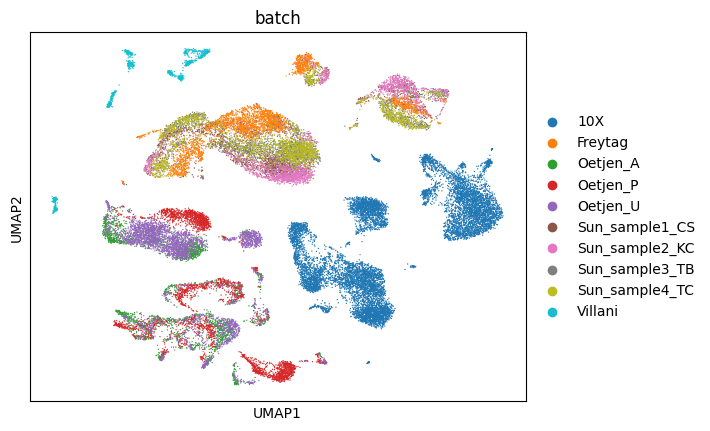

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


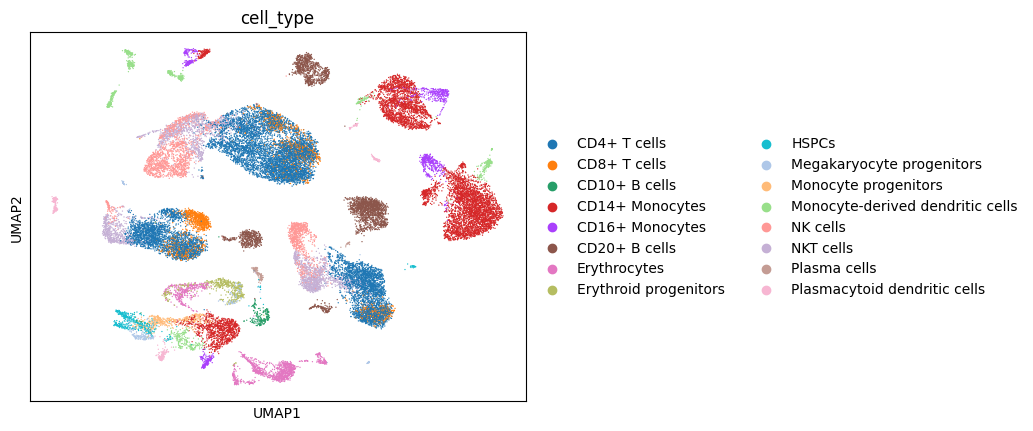

In [ ]:
sc.pp.neighbors(adata2) # Running this might take a while each time, be patient as you need to compute the neighborhood to plot the UMAP
sc.tl.umap(adata2)
sc.pl.umap(adata2, color=['batch'], use_raw=False)
sc.pl.umap(adata2, color=['cell_type'], use_raw=False)

As you can see, cells with the same type, are being plotted in different parts of our UMAP (bottom plot) and you can see in the top plot that it is because of their batch effect. They could have been gathered and reported in different laboratories, conditions, and using different technologies.

This brings instability and bias to our analysis. We want to be able to show that cells from the same type are similar to each other.

To address this issue, we need to perform `Batch Correction`.

For this section, we are mentioning 6 methods that could be used to correct the batch effects. You may choose 3 of them to use in your analysis.
- ComBat [[Johnson et al.]](https://academic.oup.com/biostatistics/article/8/1/118/252073)
- limma [[Ritchie et al.]](https://academic.oup.com/nar/article/43/7/e47/2414268)
- Scanorama [[Hie et al.]](https://www.nature.com/articles/s41587-019-0113-3)
- MNN Correct [[Haghverdi et al.]](https://www.nature.com/articles/nbt.4091)
- fastMNN [[Aaron Lun]](https://marionilab.github.io/FurtherMNN2018/theory/description.html)
- BBKNN [[Polański et. al]](https://academic.oup.com/bioinformatics/article/36/3/964/5545955?login=false)

Finally, compare your results from using these different techniques in detail. Please use a lot of plots :))

---


*   Please explain one of your chosen algorithms in detail.

    <code> Your Answer </code>

---


*   Please mention your reasons for choosing the 3 algorithms you chose, among the proposed 6.

    <code> Your Answer </code>

---


*   Please mention some of the problems that could occur in further analysis and work, if batch correction is not performed

    <code> Your Answer </code>

## Feature Selection (Highly Variable Genes)

We extract highly variable genes (HVGs) to further reduce the dimensionality of the dataset and include only the most informative genes. Genes that vary substantially across the dataset are informative of the underlying biological variation in the data. As we only want to capture biological variation in these genes, we select highly variable genes after normalization and batch correction. HVGs are used for clustering, trajectory inference, and dimensionality reduction/visualization, while the full data set is used for computing marker genes, differential testing, cell cycle scoring, and visualizing expression values on the data. [1]

Typically between 1000 and 5000 genes are selected. If particular genes of importance are known, one could assess how many highly variable genes are necessary to include all, or the majority, of these. [1]

You can use:

`sc.pp.highly_variable_genes`

[1] `Luecken MD, Theis FJ. Current best practices in single-cell RNA-seq analysis: a tutorial. 2019`

---


*   Please explain, how the algorithm you used, is choosing the Highly Variable Genes.

    <code> Your Answer </code>

---


*   Why is using HVGs important while doing inference and learning on the data? Why not use the whole set of genes?

    <code> Your Answer </code>

# Clustering

Clustering is a key step in scRNA-seq analysis since it can give us insights to better understant our data, find relations between different conditions in cells, identify the cell types and the state of the cell.

Among different algorithms available to perform clustering, `Louvain` algorithm is a common algorithm in single cell analysis. (The Louvain algorithm has been proposed for single-cell analysis by [[Levine15]](https://scanpy.readthedocs.io/en/stable/references.html#levine15).)

In `scanpy`, louvain is performed on the highly variable gene data, dimensionality reduced by PCA, and embedded into a KNN graph by default. So make sure to run `pca`, `neighbors`, and `umap (to visualize)` after computing the HVGs and before running `louvain`. (see `sc.pp.pca()` and `sc.pp.neighbors()`)

You can try different `resolutions` for `louvain` to find a fit clustering. (Visualize each clustering regarding to each resolution)

## Marker Genes Identification

To gain informative data from our clustering, we can identify the marker genes in each cluster. We expect each cluster to be able to contain a group of specific cells (e.g. based on cell types, drugs, other perturbations).

Therefore, we can also expect to find a number of genes in each cluster that are up-regulated compared to all other clusters. This is performed by computing a ranking for the highly differential genes in each cluster and comparing them to each other.

This task can be done using the `sc.tl.rank_genes_groups` function of `scanpy` which uses `t-test` by default and is performed on the `.raw` dataset which is uncorrected and contains all genes. All genes are taken into account, as any gene may be an informative marker.

You need to specify your clustering's name from `obsm` so scanpy can rank the marker genes with regarding to those clusters (`groupby`).

You can then plot the result of the marker gene analysis using `sc.pl.rank_genes_groups`

## Cluster Annotation

A lot of research and work has been done on understaning the functionality and behaviour of different genes. A very interesting aspect of this part of the literature, is that various databases has been created using prior knowledge and large-scale analysis, to capture information about cells, based on their expressed genes.

For example, you can use [PanglaoDB](https://panglaodb.se/search.html)'s search function which uses data from 1368 scRNA-seq datasets to find cell types where a certain set of gene(s) are expressed.

Using the Marker Genes you found for each cluster, create a list of most possible cell types for each cluster using `PanglaoDB` mentioned above and annotate your clusters with the cell types you abtained. You can use the overlap of top-n probable cell line of the top-m marker genes for each cluster. Or any other approach that you can think of.

Now to see how cool this is :)), plot your annotated clusters alongside with the original cell type information in your dataset, and see if you have found good clusters with correct annotations. (Your clusters are expected to represent cell types and the cell types you obtain from the Marker Genes are expected to be the same as the true cell types)

You can try different settings for `neighboring`, `clustering`, and choosing the `cell type` based on the `marker genes` to find the most informative and correct results.

---


*   How are the most highly differential genes in each cluster, valid representatives of the cell line of the cells in that cluster? Please try to read some of the works done in this area and explain as much as you can.

    <code> Your Answer </code>

# Proposed Topics for Phase 2



*   RNA Velocity
*   Batch Correction using ML-based Models
 *  Using Variational Autoencoders
 * Normalizing Flows for Distribution Matching
 * Graph-based Approaches

*   scGPT: Fine-tuning organ-specific models for downstream tasks (new and hot!)
*   Any Differential Expression analysis with corresponding results
* Trajectory Inference models
* Drug/Genetic perturbation response prediction on cells
* Multi-Modal Single-cell: Integrating different modalities of single-cell datasets


